# Hotel Booking Cancellation Prediction



In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime
from scipy.stats import zscore
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

## Load & Inspect the Data

In [41]:
df = pd.read_csv('dataset.csv')

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

display(df.head())

print(f"Dataset shape: {df.shape}")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

,booking_id,number_of_adults,number_of_children,number_of_weekend_nights,number_of_week_nights,type_of_meal,car_parking_space,room_type,lead_time,market_segment_type,repeated,p-c,p-not-c,average_price,special_requests,date_of_reservation,booking_status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


Dataset shape: (36285, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   booking_id                36285 non-null  object 
 1   number_of_adults          36285 non-null  int64  
 2   number_of_children        36285 non-null  int64  
 3   number_of_weekend_nights  36285 non-null  int64  
 4   number_of_week_nights     36285 non-null  int64  
 5   type_of_meal              36285 non-null  object 
 6   car_parking_space         36285 non-null  int64  
 7   room_type                 36285 non-null  object 
 8   lead_time                 36285 non-null  int64  
 9   market_segment_type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  p-c                       36285 non-null  int64  
 12  p-not-c                   36285 non-null  int64  
 13  average_price             36285 no

## Data Cleaning

In [43]:
df['date_of_reservation'] = pd.to_datetime(df['date_of_reservation'], errors='coerce')

print("Missing dates before filling:", df['date_of_reservation'].isnull().sum())
median_date = df['date_of_reservation'].median()
df['date_of_reservation'] = df['date_of_reservation'].fillna(median_date)
print("Missing dates after filling:", df['date_of_reservation'].isnull().sum())

print('Converted date_of_reservation values:')
display(df['date_of_reservation'].head())

Missing dates before filling: 0
Missing dates after filling: 0
Converted date_of_reservation values:


0   2015-10-02
1   2018-11-06
2   2018-02-28
3   2017-05-20
4   2018-04-11
Name: date_of_reservation, dtype: datetime64[ns]

# Feature Engineering

In [25]:
# Convert date_of_reservation to month only
df['date_of_reservation'] = pd.to_datetime(df['date_of_reservation'], format='%Y-%m-%d')
df['reservation_month'] = df['date_of_reservation'].dt.month
df.drop('date_of_reservation', axis=1, inplace=True)

# Classify guest type and get total number
def classify_guests(row):
    if row['number_of_children'] > 0:
        return 'Family'
    elif row['number_of_adults'] == 2 and row['number_of_children'] == 0:
        return 'Couples'
    elif row['number_of_adults'] == 1 and row['number_of_children'] == 0:
        return 'Singles'
    else:
        return 'Groups'

df['guest_type'] = df.apply(classify_guests, axis=1)
df['total_guests'] = df['number_of_adults'] + df['number_of_children']
df.drop('number_of_adults', axis=1, inplace=True)
df.drop('number_of_children', axis=1, inplace=True)

# Get total number of nights
df['total_nights'] = df['number_of_weekend_nights'] + df['number_of_week_nights']
df.drop('number_of_weekend_nights', axis=1, inplace=True)
df.drop('number_of_week_nights', axis=1, inplace=True)

# Irrelevant columns
df.drop('booking_id', axis=1, inplace=True)
df.drop('type_of_meal', axis=1, inplace=True)

display(df.head())
df.shape

,car_parking_space,room_type,lead_time,market_segment_type,repeated,p-c,p-not-c,average_price,special_requests,booking_status,reservation_month,guest_type,total_guests,total_nights
0,0,Room_Type 1,224,Offline,0,0,0,88.00,0,Not_Canceled,10,Family,2,7
1,0,Room_Type 1,5,Online,0,0,0,106.68,1,Not_Canceled,11,Singles,1,4
2,0,Room_Type 1,1,Online,0,0,0,50.00,0,Canceled,2,Family,3,4
3,0,Room_Type 1,211,Online,0,0,0,100.00,1,Canceled,5,Singles,1,2
4,0,Room_Type 1,48,Online,0,0,0,77.00,0,Canceled,4,Singles,1,3


(36285, 14)

## Preprocessing

In [26]:
df['repeated'] = df['repeated'].astype(str)
df['car_parking_space'] = df['car_parking_space'].astype(str)
df['reservation_month'] = df['reservation_month'].astype(str)

numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Remove duplicates
# df.drop_duplicates(inplace=True)

# Standardization
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Encoding
for col in categorical_cols:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])

display(df.head())
df.shape

,car_parking_space,room_type,lead_time,market_segment_type,repeated,p-c,p-not-c,average_price,special_requests,booking_status,reservation_month,guest_type,total_guests,total_nights
0,0,0,1.614661,3,0,-0.063385,-0.087444,-0.439538,-0.788212,1,1,1,0.076574,2.231109
1,0,0,-0.933699,4,0,-0.063385,-0.087444,0.092868,0.483646,1,2,3,-1.461055,0.551354
2,0,0,-0.980244,4,0,-0.063385,-0.087444,-1.522592,-0.788212,0,4,1,1.614204,0.551354
3,0,0,1.463389,4,0,-0.063385,-0.087444,-0.097521,0.483646,0,7,3,-1.461055,-0.568483
4,0,0,-0.433336,4,0,-0.063385,-0.087444,-0.753054,-0.788212,0,6,3,-1.461055,-0.008564


(36285, 14)

# Handling Outliers

In [27]:
z_scores = np.abs(zscore(df[numeric_cols]))
mask = (z_scores < 3).all(axis=1)
df = df[mask]

df.shape

(33469, 14)

# Train-Test Split

In [28]:
X = df.drop('booking_status', axis=1)
y = df['booking_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (26775, 13)
Testing set shape: (6694, 13)


# Logistic Regression Model

Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}

Model Accuracy: 0.8015

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.59      0.66      2169
           1       0.82      0.90      0.86      4525

    accuracy                           0.80      6694
   macro avg       0.78      0.75      0.76      6694
weighted avg       0.80      0.80      0.79      6694

F1 Score: 0.8598840274117027


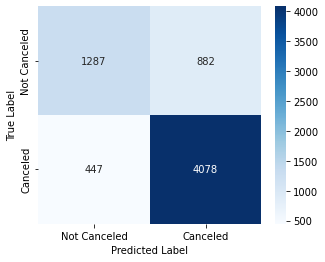

In [29]:
param_grid = {
  'C': [0.01, 0.1, 1, 10, 100],
  'penalty': ['l1', 'l2'],
  'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
model = grid_search.best_estimator_

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("F1 Score:", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Canceled", "Canceled"], yticklabels=["Not Canceled", "Canceled"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Random Forest Model

Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Model Accuracy: 0.8972

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2169
           1       0.92      0.93      0.92      4525

    accuracy                           0.90      6694
   macro avg       0.89      0.88      0.88      6694
weighted avg       0.90      0.90      0.90      6694

F1 Score: 0.9245614035087719


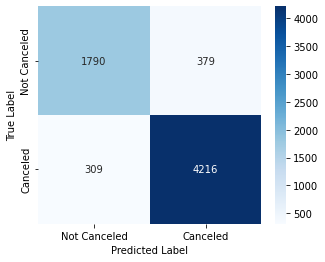

In [30]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
model = grid_search.best_estimator_

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("F1 Score:", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Canceled", "Canceled"], yticklabels=["Not Canceled", "Canceled"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# KNN Model

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 28, 'weights': 'distance'}

Model Accuracy: 0.8794

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      2169
           1       0.90      0.92      0.91      4525

    accuracy                           0.88      6694
   macro avg       0.87      0.86      0.86      6694
weighted avg       0.88      0.88      0.88      6694

F1 Score: 0.9118514472965592


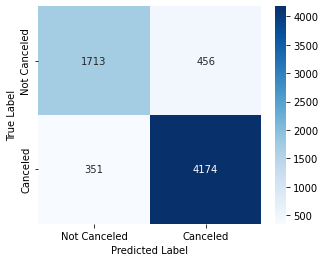

In [36]:
param_grid = {
    'n_neighbors': np.arange(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
model = grid_search.best_estimator_

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("F1 Score:", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Canceled", "Canceled"], yticklabels=["Not Canceled", "Canceled"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Logistic Regression Model with fixing imbalanced data in the training set


Training target distribution before resampling:
booking_status
1    18110
0     8665
Name: count, dtype: int64

Training target distribution after SMOTE:
booking_status
1    17438
0    17438
Name: count, dtype: int64
Best Parameters: {'C': 0.01, 'solver': 'lbfgs'}

Model Accuracy: 0.7817

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.78      0.70      2169
           1       0.88      0.78      0.83      4525

    accuracy                           0.78      6694
   macro avg       0.76      0.78      0.76      6694
weighted avg       0.80      0.78      0.79      6694

F1 Score: 0.829262592029917


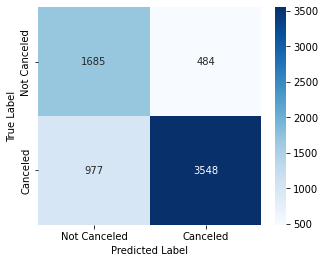

In [37]:
print("\nTraining target distribution before resampling:")
print(y_train.value_counts())

smote = SMOTETomek(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nTraining target distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000), param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

print("Best Parameters:", grid_search.best_params_)
model = grid_search.best_estimator_

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("F1 Score:", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Canceled", "Canceled"], yticklabels=["Not Canceled", "Canceled"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()